In [1]:
#@title Imports
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers
!pip install adjustText

import numpy as np
import pandas as pd
import math
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import string
import gensim
import re
import tqdm
import os
import pickle
from gensim.models import Word2Vec
from urllib.parse import urlparse
from sklearn import preprocessing
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,accuracy_score,precision_score,recall_score
from sklearn.model_selection import cross_val_score
from transformers import InputExample, WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer, glue_convert_examples_to_features as convert_examples_to_features
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from adjustText import adjust_text

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

Mounted at /content/drive
     |████████████████████████████████| 2.1MB 16.9MB/s 
     |████████████████████████████████| 3.3MB 55.6MB/s 
     |████████████████████████████████| 901kB 50.3MB/s 
  Created wheel for adjustText: filename=adjustText-0.7.3-cp37-none-any.whl size=7100 sha256=628c65f911d5d2668be3c6ed172f869afee84c170ce9c17cc51a034f3e039b3e
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
#@title Helper Functions

# Obtain AUC score
def get_auc_fpr_tpr(clf, X_test, y_test):
  probs = clf.predict_proba(X_test)[:, 1]

  fpr, tpr, _ = roc_curve(y_test, probs)
  auc = roc_auc_score(y_test, probs)

  return auc, fpr, tpr

# Plot ROC
def plot_ROC(auc,fpr,tpr):
  plt.figure(figsize=(8,8))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='AUC {:.3f}'.format(auc))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

# Training and validation accuracy/loss curves
def plot_train_val(x, train, val, train_label, val_label, title):
  plt.plot(x, train, label=train_label)
  plt.plot(x, val, label=val_label)
  plt.legend(loc='best')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.show()

# Tokenize for wordclouds
def tokenize_content(content):
  tokens = nltk.word_tokenize(content)
  tokens = [x.lower() for x in tokens if x.isalpha() == True]
  tokens = [i for i in tokens if (i in stopwords) == False]

  return tokens

# Obtain word frequencies
def word_freq(word_list):
  tokens = [tokenize_content(i) for i in word_list]
  tokens = [j for i in tokens for j in i]

  counter = Counter()
  for word in tokens:
      counter[word] += 1
    
  return tokens, counter

# Ignore certain words for wordcloud
def ignore(counter):
  for word in list(counter):
      if word in ['rt','amp','http','https','user']:
          del counter[word]
  return counter

# Plot wordcloud
def generate_wordcloud(counter):
  plt.figure(figsize=(8,8))
  wordcloud = WordCloud(background_color='white').generate_from_frequencies(counter)
  plt.imshow(wordcloud)#, interpolation="bilinear")
  plt.axis("off")
  plt.show()


# Average word vectors for a set of words
def make_feature_vec(words, model, num_features):
    feature_vec = np.zeros((num_features,),dtype='float32')
    nwords = 0
    vocab = set(model.wv.vocab)  # get words known to the model

    for word in words:
        if word in vocab: 
            nwords = nwords + 1
            feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)

    return feature_vec

# Calculate average feature vectors for all tweets
def get_avg_feature_vecs(tweets, model, num_features):
    counter = 0
    tweet_feature_vecs = np.zeros((len(tweets),num_features), dtype='float32')
    
    for tweet in tweets:
        tweet_feature_vecs[counter] = make_feature_vec(tweet, model, num_features)
        counter = counter + 1

    return tweet_feature_vecs

# Generates tf-idf matrix
def tfidf_preprocess(data, vectorizer):
  X_tfidf = vectorizer.transform(data)
  words = vectorizer.get_feature_names()
  X_tfidf = pd.DataFrame(X_tfidf.toarray())
  X_tfidf.columns = words

  return X_tfidf

In [16]:
# loading a pre-trained model
# from nltk.data import find
# nltk.download('word2vec_sample')
# word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
# model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

In [17]:
# Load own trained model
model = Word2Vec.load("/content/drive/Shareddrives/CIS522: US Political Tweets/word2vec.model")

In [18]:
pd.options.mode.chained_assignment = None  # default='warn'

In [19]:
# Load most common words from each party (extracted and saved for convenience)
path = '/content/drive/Shareddrives/CIS522: US Political Tweets/'

with open(path + "dem_most_common_words.txt", "rb") as fp:
  dem_most_common_words = pickle.load(fp)

with open(path + "rep_most_common_words.txt", "rb") as fp:
  rep_most_common_words = pickle.load(fp)

In [20]:
# Modify this to be where you saved the data
# df =  pd.read_csv('/content/drive/My Drive/CIS522_Final_Project/tweets_labeled.csv',engine='python', encoding='latin-1')

# Sally's path
df =  pd.read_csv('/content/drive/Shareddrives/CIS522: US Political Tweets/data/tweets_labeled.csv',engine='python', encoding='latin-1')
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CIS 522/Project/tweets_labeled.csv',engine='python',encoding='latin-1')

# Data Cleaning & Exploratory Data Analysis

In [21]:
# Change to datetime
df['created_at'] = pd.to_datetime(df['created_at'])

In [22]:
# Since Independents typically caucus with Democrats, we'll name them as such for the purposes of this analysis
df['party'] = df['party'].apply(lambda x: 'Democrat' if x == 'Independent' else x)

In [23]:
# Also, since there is only one Libertarian, we will drop from the dataframe (3,225 rows)
df = df[df['party'] != 'Libertarian']

Text(0.5, 1.0, 'Number of Examples in Dataset by Party')

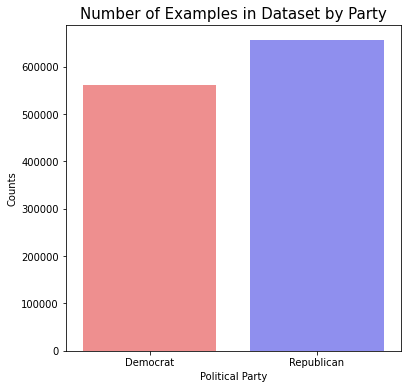

In [ ]:
# Breakdown of tweets by party -- data is pretty balanced
df['party'].value_counts()

party = df.groupby('party').count().reset_index()[['party','id']]

values = np.array(party.party) 
colors = ['red' if x == 'Democrat' else 'blue' for x in values ]

plt.figure(figsize=(6,6))
ax = sns.barplot(x='party',y='id',data=party,palette=colors,alpha=0.5)
ax.set(xlabel='Political Party', ylabel='Counts')
plt.title("Number of Examples in Dataset by Party", fontsize=15)

Text(0.5, 1.0, 'Number of Examples in Dataset by Gender')

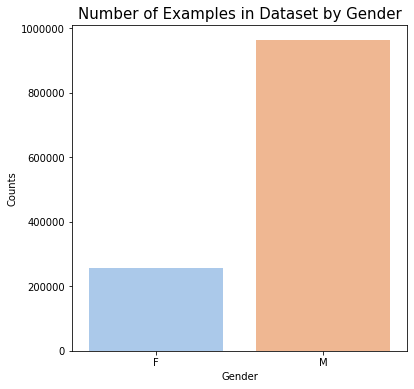

In [ ]:
# Breakdown of tweets by gender -- data is pretty unbalanced which we should account for in our models
df['gender'].value_counts()

gender = df.groupby('gender').count().reset_index()[['gender','id']]

plt.figure(figsize=(6,6))
ax = sns.barplot(x='gender',y='id',data=gender,palette='pastel')
ax.set(xlabel='Gender', ylabel='Counts')
plt.ticklabel_format(style='plain', axis='y')
plt.title("Number of Examples in Dataset by Gender", fontsize=15)

## Clean tweets

In [24]:
def remove_tags(text):
  new_text = []
  for t in text.split(" "):
    t = '@user' if t.startswith('@') and len(t) > 1 else t
    t = 'http' if t.startswith('http') else t
    new_text.append(t)
  return " ".join(new_text)

In [25]:
def clean_tweet(text):
  lemmatizer = WordNetLemmatizer()

  text = text.replace("\"",'').replace('\'s','').replace('\n',' ').replace('...', ' ')     # Remove double quotations and "'s" and \n
  text = remove_tags(text)
  text = ' '.join([tweet for tweet in text.split() if not tweet.startswith("&")])         # Remove any words starting with & (typically incorrectly parsed signs)
  text = ' '.join([tweet for tweet in text.split() if not tweet.startswith("#")])         # Remove hashtags
  text = re.sub("[^\w\s]",' ',text)
  text = text.lower()                                                                     # Change to lowercase
  text = ' '.join([tweet for tweet in text.split() if not tweet.lower() in stopwords])    # Remove stopwords
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])                  # Lemmatize (stemming: over-stemmed too much, decided not to use)
  text = ' '.join([tweet for tweet in text.split() if not any(c.isdigit() for c in tweet)])   # Remove numbers
  text = ' '.join([tweet for tweet in text.split() if tweet.lower() != 'rt'])             # Remove retweets
  text = ''.join([i for i in text if ord(i) < 128])                                       # Remove odd characters

  return text

In [26]:
df['clean_tweet'] = df['text'].apply(clean_tweet)

#### Remove most common words

In [27]:
# Get top 200 most common words from each party
num_top = 200
all_common = dem_most_common_words[:num_top] + rep_most_common_words[:num_top]

In [28]:
# Just get words
common_words = []
for x,y in all_common:
  common_words.append(x)

In [29]:
df['no_common'] = df['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if not word in common_words]))

#### Trained own Word2Vec Model

 (DO NOT RUN AGAIN; OTHERWISE RENAME SAVED MODEL)

In [ ]:
tweets = list(df['clean_tweet'])
tweets = ' '.join([tweet + '.' for tweet in tweets])

In [ ]:
all_sentences = nltk.sent_tokenize(tweets)

In [ ]:
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]

In [ ]:
model = Word2Vec(all_words, min_count=2, workers=4)

In [ ]:
#model.save("/content/drive/Shareddrives/CIS522: US Political Tweets/word2vec.model")

In [ ]:
vocab = list(model.wv.vocab)
print(vocab)
len(vocab)

['conference', 'call', 'weekend', 'trip', 'iraq', 'visit', 'arkansas', 'troop', '.', 'interviewed', 'kthv', 'karn', 'world', 'trade', 'center', 'kwhn', 'fort', 'smith', 'attending', 'military', 'purple', 'heart', 'ceremony', 'va', 'medical', 'fayetteville', 'touring', 'helath', 'south', 'hospital', 'conducting', 'veteran', 'affair', 'economic', 'opportunity', 'subcommittee', 'field', 'hearing', 'northwest', 'community', 'college', 'interview', 'kurm', 'radio', 'meeting', 'emergency', 'management', 'official', 'johnson', 'pope', 'franklin', 'county', 'listening', 'constituent', 'roundtable', 'discussion', 'gas', 'price', 'flippin', 'gop', 'convention', 'transportation', 'infrastructure', 'committee', 'h', 'r', 'taking', 'responsible', 'action', 'safety', 'act', 'foreign', 'relation', 'u', 'russia', 'aftermath', 'georgia', 'crisis', 'voting', 'joint', 'adoption', 'rule', 'provide', 'consideration', 'national', 'capital', 'security', 'whip', 'team', 'water', 'resource', 'ordering', 'previ

64547

In [ ]:
print('Result embedding shape:', model.wv.vectors.shape)

Result embedding shape: (64547, 100)


In [ ]:
model.most_similar('twitter')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('instagram', 0.6887608766555786),
 ('tweet', 0.6783918738365173),
 ('hashtag', 0.6634150147438049),
 ('follower', 0.6538665890693665),
 ('fb', 0.6447388529777527),
 ('facebook', 0.6431940793991089),
 ('reply', 0.6362739205360413),
 ('snapchat', 0.6031785011291504),
 ('liking', 0.5468494296073914),
 ('youtube', 0.5379019379615784)]

## Wordcloud - Hashtags

In [ ]:
df['hashtags_str'] = df['hashtags'].apply(lambda x: x.replace("[","").replace("]","").replace('\'',''))

In [ ]:
# Obtain tweets split by party
democrat = list(df[df['party'] == 'Democrat']['hashtags_str'])
republican = list(df[df['party'] == 'Republican']['hashtags_str'])

In [ ]:
# Tokenize and obtain word frequencies from tweets
democrat_tokens, democrat_counter = word_freq(democrat)
republican_tokens, republican_counter = word_freq(republican)

In [ ]:
# Obtain the difference so words that both parties use a lot are removed
difference_democrat_counter = democrat_counter - republican_counter
difference_republican_counter = republican_counter - democrat_counter

In [ ]:
difference_democrat_counter.most_common(20)

[('aca', 5133),
 ('trumpcare', 4630),
 ('actonclimate', 2454),
 ('doyourjob', 2435),
 ('raisethewage', 2174),
 ('lgbt', 2024),
 ('disarmhate', 2011),
 ('equalpay', 1956),
 ('nobillnobreak', 1860),
 ('lagov', 1689),
 ('climatechange', 1681),
 ('gopshutdown', 1587),
 ('gunviolence', 1504),
 ('renewui', 1438),
 ('zika', 1398),
 ('netde', 1372),
 ('getcovered', 1365),
 ('ri', 1201),
 ('mtpol', 1192),
 ('protectourcare', 1172)]

In [ ]:
difference_republican_counter.most_common(20)

[('obamacare', 12527),
 ('tcot', 8620),
 ('utpol', 4815),
 ('irs', 2878),
 ('smallbiz', 2750),
 ('betterway', 1991),
 ('keystonexl', 1974),
 ('iran', 1774),
 ('sctweets', 1652),
 ('idpol', 1632),
 ('jobs', 1511),
 ('gop', 1417),
 ('epa', 1362),
 ('benghazi', 1347),
 ('irandeal', 1314),
 ('arpx', 1290),
 ('southjersey', 1223),
 ('prolife', 1206),
 ('ksleg', 1161),
 ('ff', 1138)]

Text(0.5, 1.0, 'Top 20 Hashtags Used by Democrats')

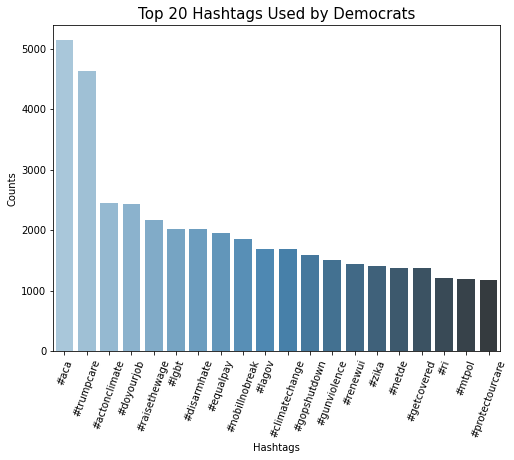

In [ ]:
word = []
count = []
for x,y in difference_democrat_counter.most_common(20):
  word.append('#'+x)
  count.append(y)
dem_top_20 = pd.DataFrame(zip(word,count))

plt.figure(figsize=(8,6))
ax = sns.barplot(x=0,y=1,data=dem_top_20,palette='Blues_d')
ax.set(xlabel='Hashtags', ylabel='Counts')
for item in ax.get_xticklabels():
    item.set_rotation(70)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Top 20 Hashtags Used by Democrats", fontsize=15)

Text(0.5, 1.0, 'Top 20 Hashtags Used by Republicans')

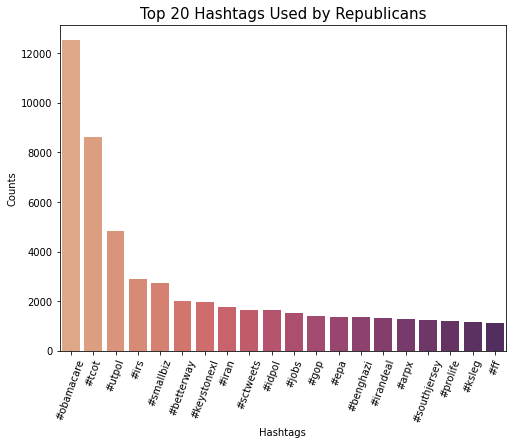

In [ ]:
word = []
count = []
for x,y in difference_republican_counter.most_common(20):
  word.append('#'+x)
  count.append(y)
rep_top_20 = pd.DataFrame(zip(word,count))

plt.figure(figsize=(8,6))
ax = sns.barplot(x=0,y=1,data=rep_top_20,palette="flare")
ax.set(xlabel='Hashtags', ylabel='Counts')
for item in ax.get_xticklabels():
    item.set_rotation(70)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Top 20 Hashtags Used by Republicans", fontsize=15)

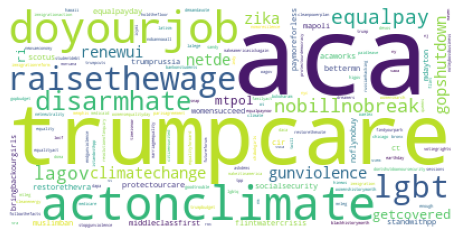

In [ ]:
generate_wordcloud(difference_democrat_counter)

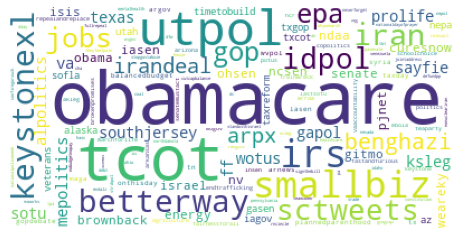

In [ ]:
generate_wordcloud(difference_republican_counter)

## Wordcloud - Tweets

### By Party

In [ ]:
# Obtain tweets split by party
democrat = list(df[df['party'] == 'Democrat']['text'])
republican = list(df[df['party'] == 'Republican']['text'])

In [ ]:
# Tokenize and obtain word frequencies from tweets
democrat_tokens, democrat_counter = word_freq(democrat)
republican_tokens, republican_counter = word_freq(republican)

In [ ]:
# Remove words from the counters that aren't meaningful as a result of cleaning
democrat_counter = ignore(democrat_counter)
republican_counter = ignore(republican_counter)

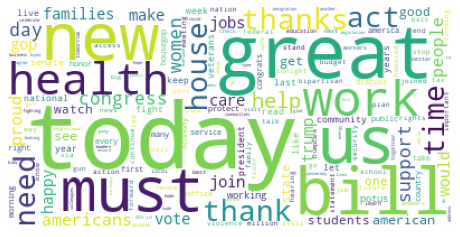

In [ ]:
generate_wordcloud(democrat_counter)

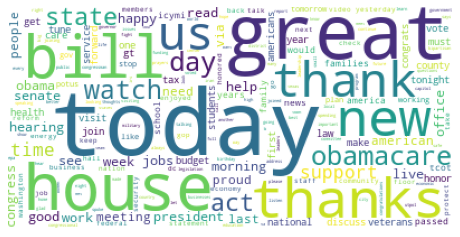

In [ ]:
generate_wordcloud(republican_counter)

In [ ]:
# Obtain the difference so words that both parties use a lot are removed
difference_democrat_counter = democrat_counter - republican_counter
difference_republican_counter = republican_counter - democrat_counter

In [ ]:
difference_democrat_counter.most_common(20)

[('women', 10381),
 ('trump', 9854),
 ('must', 9243),
 ('health', 7075),
 ('aca', 6831),
 ('gun', 5498),
 ('americans', 5491),
 ('need', 5471),
 ('violence', 5454),
 ('families', 5180),
 ('trumpcare', 4967),
 ('rights', 4193),
 ('gop', 3970),
 ('housegop', 3860),
 ('housedemocrats', 3851),
 ('let', 3821),
 ('care', 3602),
 ('fight', 3543),
 ('stand', 3541),
 ('equality', 3363)]

In [ ]:
difference_republican_counter.most_common(20)

[('obamacare', 19041),
 ('today', 16416),
 ('great', 13869),
 ('obama', 11217),
 ('house', 11172),
 ('morning', 8925),
 ('watch', 8736),
 ('gt', 8717),
 ('tcot', 8635),
 ('hearing', 7649),
 ('live', 7458),
 ('president', 7364),
 ('week', 7252),
 ('state', 7072),
 ('via', 7051),
 ('thanks', 6405),
 ('meeting', 6277),
 ('county', 6254),
 ('office', 5887),
 ('tune', 5722)]

Text(0.5, 1.0, 'Top 20 Words Used by Democrats')

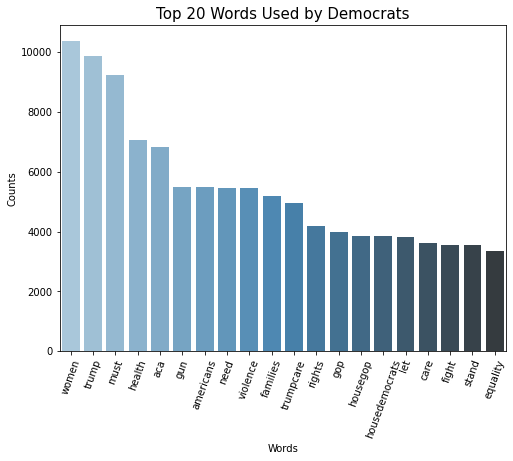

In [ ]:
word = []
count = []
for x,y in difference_democrat_counter.most_common(20):
  word.append(x)
  count.append(y)
dem_top_20 = pd.DataFrame(zip(word,count))

plt.figure(figsize=(8,6))
ax = sns.barplot(x=0,y=1,data=dem_top_20,palette='Blues_d')
ax.set(xlabel='Words', ylabel='Counts')
for item in ax.get_xticklabels():
    item.set_rotation(70)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Top 20 Words Used by Democrats", fontsize=15)

Text(0.5, 1.0, 'Top 20 Words Used by Republicans')

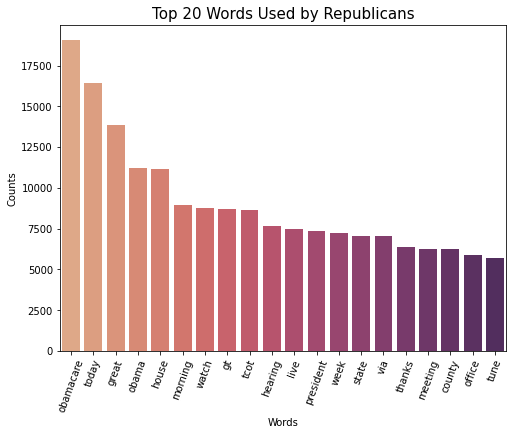

In [ ]:
word = []
count = []
for x,y in difference_republican_counter.most_common(20):
  word.append(x)
  count.append(y)
rep_top_20 = pd.DataFrame(zip(word,count))

plt.figure(figsize=(8,6))
ax = sns.barplot(x=0,y=1,data=rep_top_20,palette="flare")
ax.set(xlabel='Words', ylabel='Counts')
for item in ax.get_xticklabels():
    item.set_rotation(70)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Top 20 Words Used by Republicans", fontsize=15)

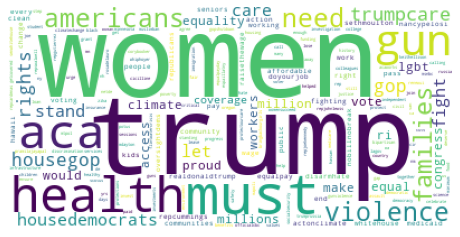

In [ ]:
generate_wordcloud(difference_democrat_counter)

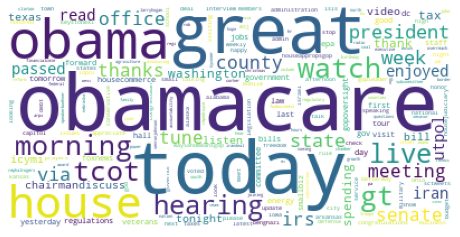

In [ ]:
generate_wordcloud(difference_republican_counter)

### By Gender

In [ ]:
# Obtain tweets split by gender
female = list(df[df['gender'] == 'F']['text'])
male = list(df[df['gender'] == 'M']['text'])

In [ ]:
# Tokenize and obtain word frequencies from tweets
female_tokens, female_counter = word_freq(female)
male_tokens, male_counter = word_freq(male)

In [ ]:
# Remove words that aren't meaningful
female_counter = ignore(female_counter)
male_counter = ignore(male_counter)

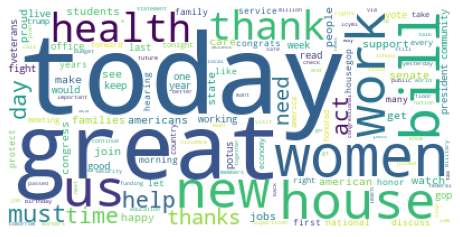

In [ ]:
generate_wordcloud(female_counter)

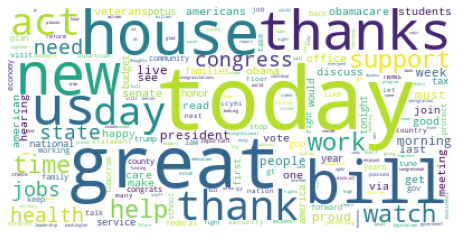

In [ ]:
generate_wordcloud(male_counter)

In [ ]:
difference_female_counter = female_counter - male_counter
difference_male_counter = male_counter - female_counter

In [ ]:
difference_female_counter.most_common(20)

[('nh', 1403),
 ('pramilajayapal', 1374),
 ('congresswoman', 1231),
 ('hassan', 1169),
 ('gabbard', 788),
 ('iasen', 783),
 ('tulsi', 736),
 ('murray', 690),
 ('cantwell', 684),
 ('stabenow', 672),
 ('repdinatitus', 664),
 ('bringbackourgirls', 647),
 ('sofla', 635),
 ('iagov', 571),
 ('womensucceed', 490),
 ('paidleave', 490),
 ('kimreynoldsia', 472),
 ('terrybranstad', 440),
 ('maxinewaters', 439),
 ('collins', 431)]

In [ ]:
difference_male_counter.most_common(20)

[('today', 64392),
 ('great', 40781),
 ('house', 29026),
 ('thanks', 27027),
 ('new', 26703),
 ('bill', 26393),
 ('us', 24219),
 ('thank', 22873),
 ('day', 20842),
 ('watch', 18892),
 ('support', 18723),
 ('act', 18529),
 ('time', 18307),
 ('state', 17854),
 ('jobs', 17658),
 ('live', 17520),
 ('obamacare', 17407),
 ('president', 17124),
 ('work', 16863),
 ('congress', 16591)]

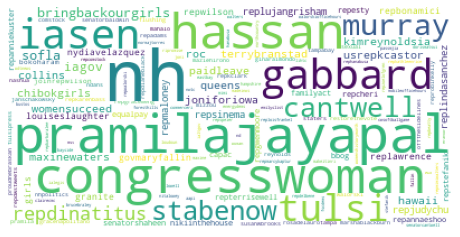

In [ ]:
generate_wordcloud(difference_female_counter)

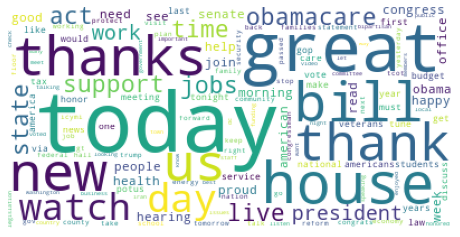

In [ ]:
generate_wordcloud(difference_male_counter)

## Visualize Word Embeddings

In [ ]:
# Obtain tweets split by party
democrat = list(df[df['party'] == 'Democrat']['clean_tweet'])
republican = list(df[df['party'] == 'Republican']['clean_tweet'])

In [ ]:
# Tokenize and obtain word frequencies from tweets
democrat_tokens, democrat_counter = word_freq(democrat)
republican_tokens, republican_counter = word_freq(republican)

In [ ]:
# Again, ignore meaningless words
democrat_counter = ignore(democrat_counter)
republican_counter = ignore(republican_counter)

In [ ]:
# Obtain the difference so words that both parties use a lot are removed
difference_democrat_counter = democrat_counter - republican_counter
difference_republican_counter = republican_counter - democrat_counter

In [ ]:
# Obtain most commonly used words from each party
dem_most_common = difference_democrat_counter.most_common(100)
rep_most_common = difference_republican_counter.most_common(100)

In [ ]:
# Obtain in list form
words_most_common = []
label = []
for x,y in dem_most_common:
  words_most_common.append(x)
  label.append('Democrat')
  
for x,y in rep_most_common:
  words_most_common.append(x)
  label.append('Republican')

In [ ]:
# Get vector representation of word embeddings
words_most_common=list(set(words_most_common))
w2v_embed = model[words_most_common]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Run t-sne to reduce to 2 components for graphing
tsne = TSNE(n_components=2, random_state=47)
embed_tsne = tsne.fit_transform(w2v_embed)

In [ ]:
# Set to dataframe
embed_df = pd.DataFrame(embed_tsne, index=words_most_common, columns=['x', 'y'])
embed_df['party'] = label

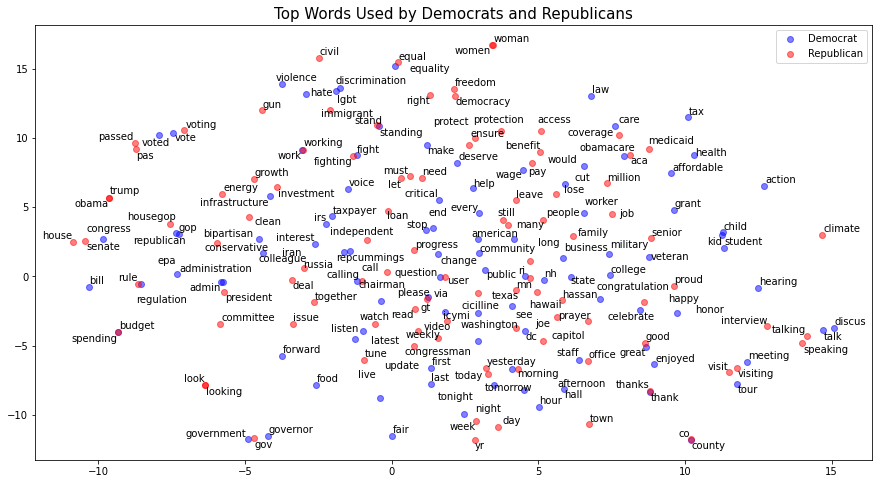

In [ ]:
# Plot word embeddings
embed_dem = embed_df[embed_df['party'] == 'Democrat']
embed_rep = embed_df[embed_df['party'] == 'Republican']

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)

x = embed_df['x']
y = embed_df['y']
label = list(embed_df.index)

ax.scatter(embed_dem['x'], embed_dem['y'],c='blue',label='Democrat',alpha=0.5)
ax.scatter(embed_rep['x'], embed_rep['y'],c='red',label='Republican',alpha=0.5)

texts = []
for x, y, s in zip(x, y, label):
  if len(s) > 1:
    texts.append(plt.text(x, y, s))

adjust_text(texts)
plt.legend()
plt.title("Top Words Used by Democrats and Republicans",fontsize=15)
plt.show()

Visualize with clusters

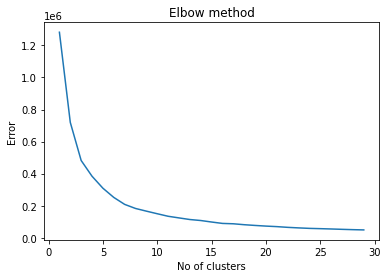

In [ ]:
from sklearn.cluster import KMeans

error =[]
for i in range(1, 30):
    kmeans = KMeans(n_clusters = i, init='k-means++',max_iter=300, n_init=10, random_state=47)
    kmeans.fit(embed_tsne)
    error.append(kmeans.inertia_)

plt.plot(range(1, 30), error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 15, init='k-means++',max_iter=300, n_init=10, random_state=47)
kmeans.fit(embed_tsne)
pred = kmeans.fit_predict(embed_tsne)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


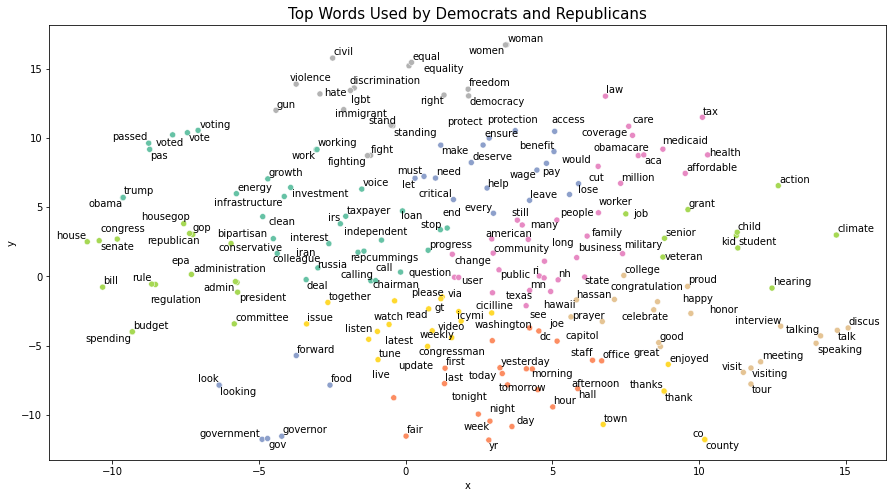

In [ ]:
# Plot word embeddings
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)

x = embed_df['x']
y = embed_df['y']
label = list(embed_df.index)

sns.scatterplot(embed_df['x'], embed_df['y'], hue=pred, palette='Set2', ax=ax, legend=False)

texts = []
for x, y, s in zip(x, y, label):
  if len(s) > 1:
    texts.append(plt.text(x, y, s))

adjust_text(texts)
plt.title("Top Words Used by Democrats and Republicans",fontsize=15)
plt.show()

# Feature Engineering

## Averaged Word Embeddings
Function definitions included in "Helper Functions" at the beginning.


*   `make_feature_vec()`
*   `get_avg_feature_vecs()`





## TF-IDF
Function definition included in "Helper Functions" at the beginning.


*   `tfidf_preprocess()`





## Cast categorical values to numeric

In [30]:
# Change gender: F-0, M-1
le = preprocessing.LabelEncoder()
le.fit(df['gender'])
df['gender']=le.transform(df['gender'])

In [31]:
# Change party: Democrat-0, Republican-1
le.fit(df['party'])
df['party']=le.transform(df['party'])

# Non-Deep Learning Baselines

In [ ]:
#@title Helper Functions Non-DL
# Change words to numeric based on mapping
def map_word_vocab(sentence):
  idxs = [vocab[w] for w in sentence.split()]
  return idxs

# Pad tweets so we can get tensors from them
def pad_tweets_array(tweet,max_len):
  while len(tweet) < max_len:
    tweet.append(0)

  if len(tweet) > max_len:
    tweet = tweet[:max_len]
  return tweet

### Democrats & Republicans
To speed up training, will need to use subset of tweets

In [ ]:
# Just randomly pick 300k from each party
df_dem = df[df['party'] == 0].sample(n=300000, random_state=47)
df_rep = df[df['party'] == 1].sample(n=300000, random_state=47)

In [ ]:
 # Stack them
 df_sample = pd.concat([df_dem,df_rep],ignore_index=True)

In [ ]:
# Pretty evenly split, no need for additional
df_sample['party'].value_counts()

1    300000
0    300000
Name: party, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_sample.drop(columns={'party'}), df_sample['party'], test_size = 0.3, random_state=47, shuffle=True)

#### TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_features=500)
tfidf_fit = vectorizer.fit(X_train['clean_tweet'])
X_train_vect = tfidf_preprocess(X_train['clean_tweet'], tfidf_fit)
X_test_vect = tfidf_preprocess(X_test['clean_tweet'], tfidf_fit)

In [ ]:
# vectorizer = TfidfVectorizer(max_features=500)
# tfidf_fit = vectorizer.fit(X_train['no_common'])
# X_train_vect = tfidf_preprocess(X_train['no_common'], tfidf_fit)
# X_test_vect = tfidf_preprocess(X_test['no_common'], tfidf_fit)

##### Random Forest

In [ ]:
# Random Forest also incorporating tf-idf
rf = RandomForestClassifier()
rf.fit(X_train_vect, y_train)
y_pred = rf.predict(X_test_vect)
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted      0      1
Actual                 
0          14150   8412
1           8303  14135
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     22562
           1       0.63      0.63      0.63     22438

    accuracy                           0.63     45000
   macro avg       0.63      0.63      0.63     45000
weighted avg       0.63      0.63      0.63     45000



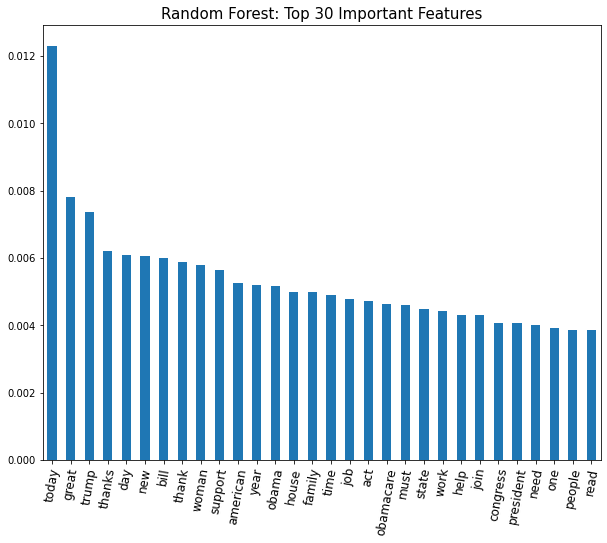

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train_vect.columns)
feat_importances.nlargest(32)[2:].plot(kind='bar',figsize=(10,8))
plt.title("Random Forest: Top 30 Important Features",fontsize=15)
plt.xticks(fontsize=12,rotation=80)
plt.show()

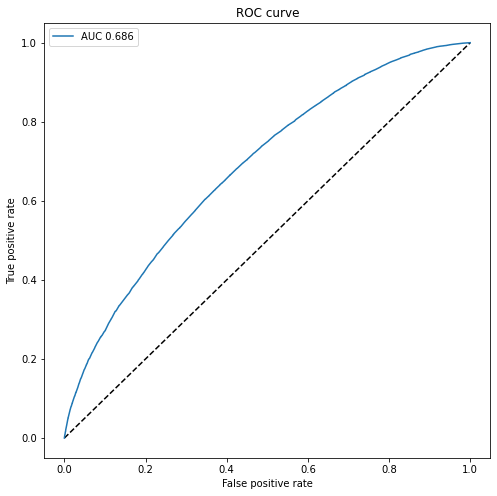

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(rf, X_test_vect, y_test)
plot_ROC(auc,fpr,tpr)

With common words removed

In [ ]:
# Random Forest also incorporating tf-idf
rf = RandomForestClassifier()
rf.fit(X_train_vect, y_train)
y_pred = rf.predict(X_test_vect)
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted      0      1
Actual                 
0          12779   9783
1           9590  12848
              precision    recall  f1-score   support

           0       0.57      0.57      0.57     22562
           1       0.57      0.57      0.57     22438

    accuracy                           0.57     45000
   macro avg       0.57      0.57      0.57     45000
weighted avg       0.57      0.57      0.57     45000



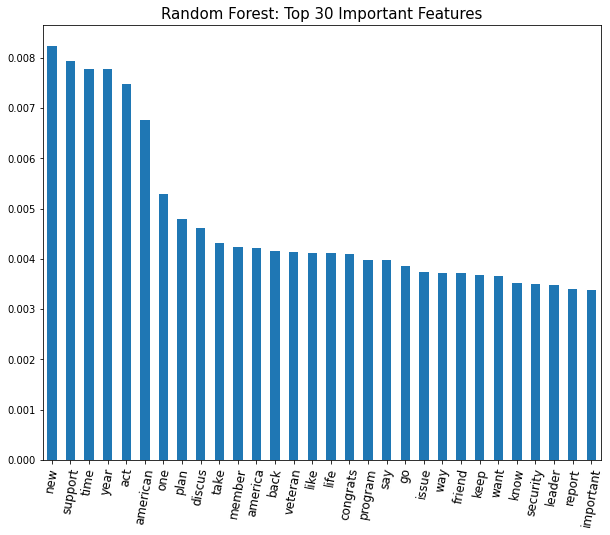

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train_vect.columns)
feat_importances.nlargest(32)[2:].plot(kind='bar',figsize=(10,8))
plt.title("Random Forest: Top 30 Important Features",fontsize=15)
plt.xticks(fontsize=12,rotation=80)
plt.show()

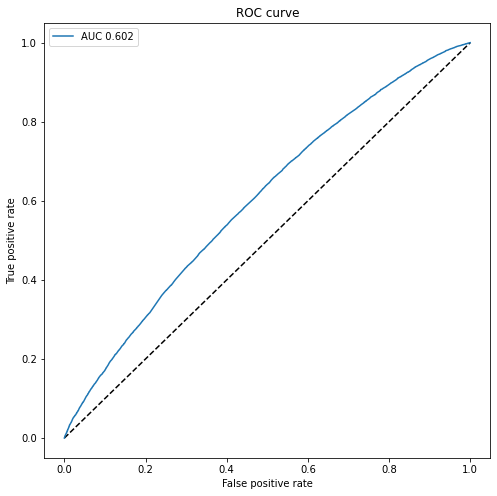

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(rf, X_test_vect, y_test)
plot_ROC(auc,fpr,tpr)

##### Logistic Regression

In [ ]:
lr = LogisticRegression(solver='saga',C=10,max_iter=10000)
lr.fit(X_train_vect, y_train)
y_pred = lr.predict(X_test_vect)
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted      0      1
Actual                 
0          13799   8763
1           8155  14283
              precision    recall  f1-score   support

           0       0.63      0.61      0.62     22562
           1       0.62      0.64      0.63     22438

    accuracy                           0.62     45000
   macro avg       0.62      0.62      0.62     45000
weighted avg       0.62      0.62      0.62     45000



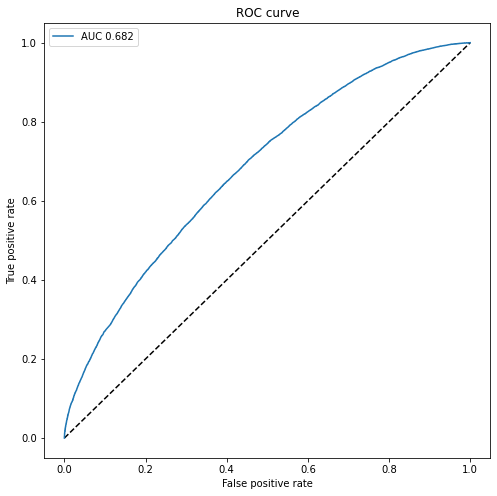

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(lr, X_test_vect, y_test)
plot_ROC(auc,fpr,tpr)

With no common words

In [ ]:
lr = LogisticRegression(solver='saga',C=10,max_iter=10000)
lr.fit(X_train_vect, y_train)
y_pred = lr.predict(X_test_vect)
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted      0      1
Actual                 
0          12551  10011
1           9073  13365
              precision    recall  f1-score   support

           0       0.58      0.56      0.57     22562
           1       0.57      0.60      0.58     22438

    accuracy                           0.58     45000
   macro avg       0.58      0.58      0.58     45000
weighted avg       0.58      0.58      0.58     45000



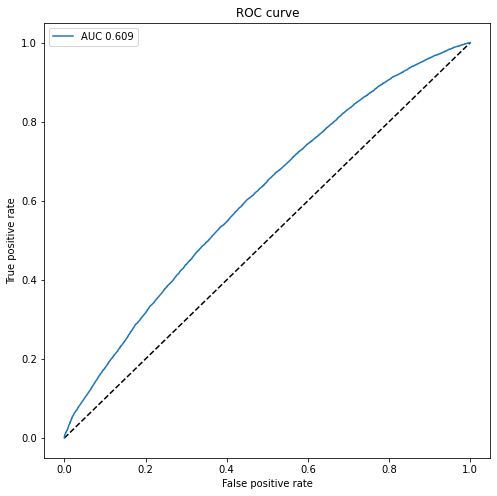

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(lr, X_test_vect, y_test)
plot_ROC(auc,fpr,tpr)

##### Gradient Boosting

In [ ]:
grad_clf = GradientBoostingClassifier()
grad_clf.fit(X_train_vect, y_train)
y_pred = grad_clf.predict(X_test_vect)
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted      0      1
Actual                 
0          11397  11165
1           6740  15698
              precision    recall  f1-score   support

           0       0.63      0.51      0.56     22562
           1       0.58      0.70      0.64     22438

    accuracy                           0.60     45000
   macro avg       0.61      0.60      0.60     45000
weighted avg       0.61      0.60      0.60     45000



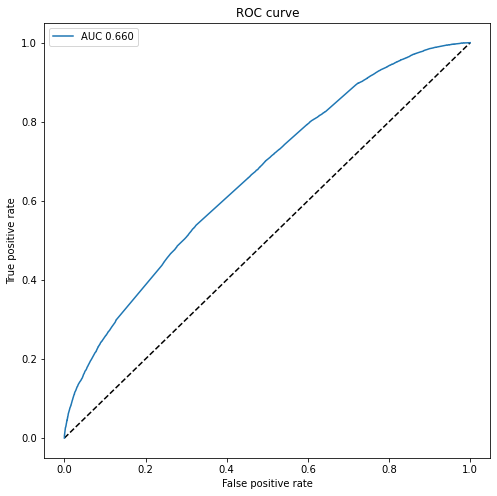

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(grad_clf, X_test_vect, y_test)
plot_ROC(auc,fpr,tpr)

##### Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(X_train_vect, y_train)
y_pred = nb.predict(X_test_vect)
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted      0      1
Actual                 
0          15035   7527
1          11363  11075
              precision    recall  f1-score   support

           0       0.57      0.67      0.61     22562
           1       0.60      0.49      0.54     22438

    accuracy                           0.58     45000
   macro avg       0.58      0.58      0.58     45000
weighted avg       0.58      0.58      0.58     45000



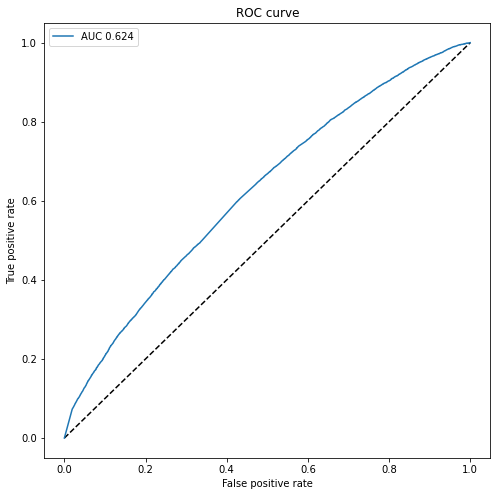

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(nb, X_test_vect, y_test)
plot_ROC(auc,fpr,tpr)

#### Text itself

In [ ]:
# Get vocab
# tweet_type = 'clean_tweet'
tweet_type = 'no_common'
tweets = list(df_sample['clean_tweet'])

vocab = {}
vocab_index = 0
for i in range(len(tweets)):
  for token in tweets[i].split():
    if token not in vocab:
      vocab[token] = vocab_index
      vocab_index += 1

In [ ]:
# Change words to numeric based on mapping
X_train = X_train[tweet_type].apply(map_word_vocab)
X_test = X_test[tweet_type].apply(map_word_vocab)

In [ ]:
# Pad tweets
X_train = pd.DataFrame(X_train.apply(lambda x: pad_tweets_array(x,20)))
X_test = pd.DataFrame(X_test.apply(lambda x: pad_tweets_array(x,20)))

In [ ]:
X_train = pd.concat([X_train[tweet_type].apply(pd.Series) for col in X_train.columns], axis=1, ignore_index=True)
X_test = pd.concat([X_test[tweet_type].apply(pd.Series) for col in X_test.columns], axis=1, ignore_index=True)

##### Random Forest

In [ ]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted      0      1
Actual                 
0          17943   4619
1          11972  10466
              precision    recall  f1-score   support

           0       0.60      0.80      0.68     22562
           1       0.69      0.47      0.56     22438

    accuracy                           0.63     45000
   macro avg       0.65      0.63      0.62     45000
weighted avg       0.65      0.63      0.62     45000



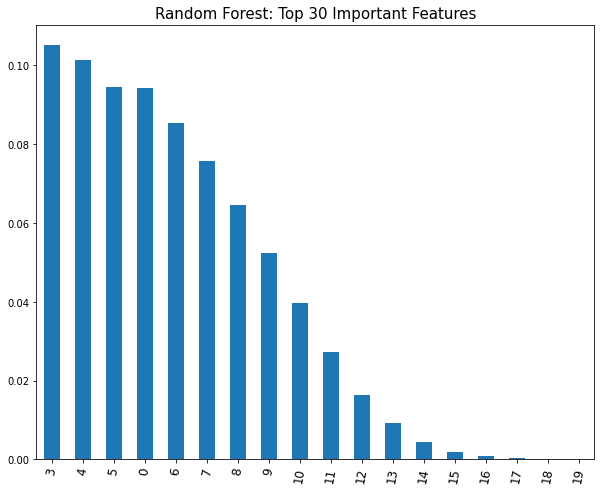

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(32)[2:].plot(kind='bar',figsize=(10,8))
plt.title("Random Forest: Top 30 Important Features",fontsize=15)
plt.xticks(fontsize=12,rotation=80)
plt.show()

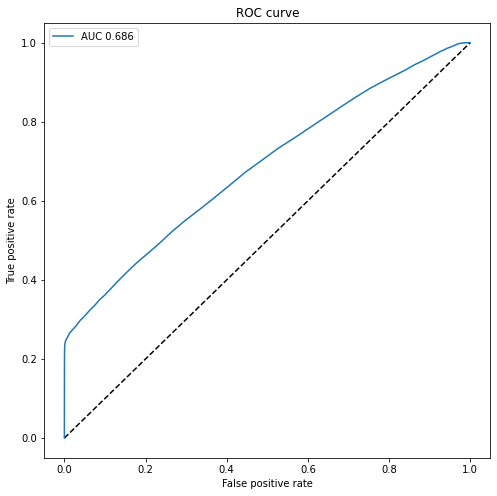

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(rf, X_test, y_test)
plot_ROC(auc,fpr,tpr)

With common words removed

In [ ]:
# Random Forest also incorporating tf-idf
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted      0      1
Actual                 
0          17571   4991
1          11597  10841
              precision    recall  f1-score   support

           0       0.60      0.78      0.68     22562
           1       0.68      0.48      0.57     22438

    accuracy                           0.63     45000
   macro avg       0.64      0.63      0.62     45000
weighted avg       0.64      0.63      0.62     45000



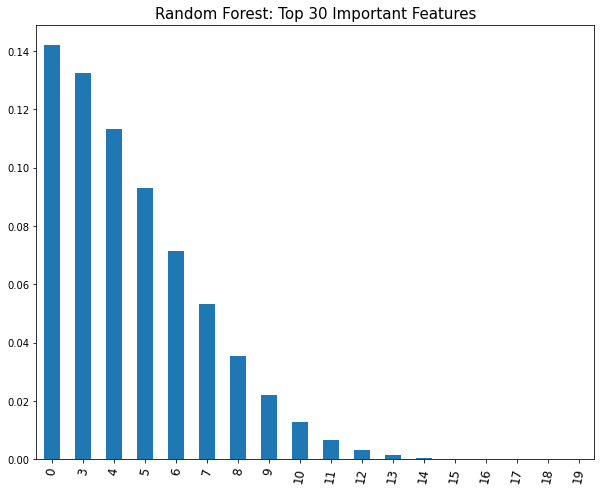

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(32)[2:].plot(kind='bar',figsize=(10,8))
plt.title("Random Forest: Top 30 Important Features",fontsize=15)
plt.xticks(fontsize=12,rotation=80)
plt.show()

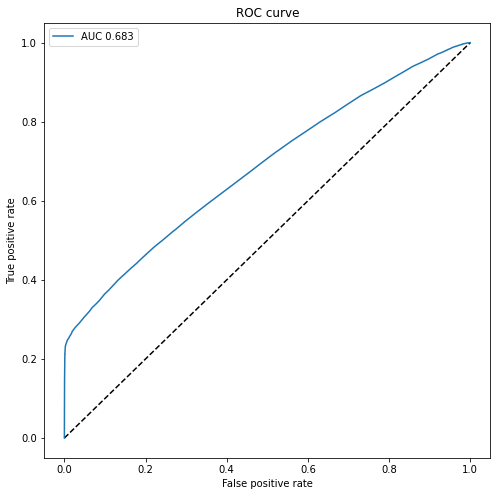

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(rf, X_test, y_test)
plot_ROC(auc,fpr,tpr)

##### Logistic Regression

In [ ]:
lr = LogisticRegression(solver='saga',C=10,max_iter=10000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted    0      1
Actual               
0          462  22100
1          486  21952
              precision    recall  f1-score   support

           0       0.49      0.02      0.04     22562
           1       0.50      0.98      0.66     22438

    accuracy                           0.50     45000
   macro avg       0.49      0.50      0.35     45000
weighted avg       0.49      0.50      0.35     45000



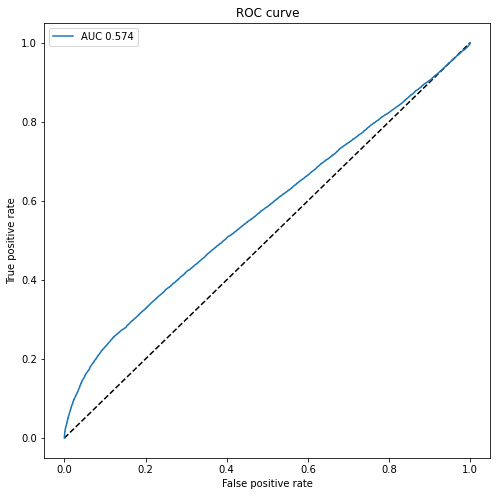

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(lr, X_test, y_test)
plot_ROC(auc,fpr,tpr)

With no common words

In [ ]:
lr = LogisticRegression(solver='saga',C=10,max_iter=10000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted    0      1
Actual               
0          486  22076
1          450  21988
              precision    recall  f1-score   support

           0       0.52      0.02      0.04     22562
           1       0.50      0.98      0.66     22438

    accuracy                           0.50     45000
   macro avg       0.51      0.50      0.35     45000
weighted avg       0.51      0.50      0.35     45000



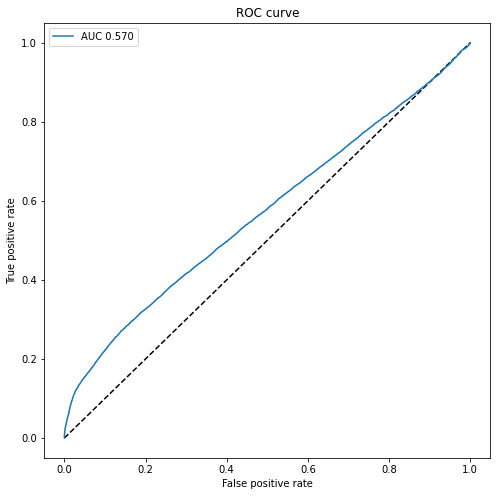

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(lr, X_test, y_test)
plot_ROC(auc,fpr,tpr)

#### Averaged Word Embeddings

In [ ]:
# Get averaged vecs for training
# Takes about 15 min to run
clean_tweets = []
clean_tweets = list(X_train['clean_tweet'].apply(lambda x: x.lower().split()))
trainDataVecs = get_avg_feature_vecs(clean_tweets, model, 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [ ]:
# Get averaged vecs for testing
# Takes about 6 min to run
clean_tweets = []
clean_tweets = list(X_test['clean_tweet'].apply(lambda x: x.lower().split()))
testDataVecs = get_avg_feature_vecs(clean_tweets, model, 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [ ]:
# NO COMMON WORDS VERSION
# clean_tweets = []
# clean_tweets = list(X_train['no_common'].apply(lambda x: x.lower().split()))
# trainDataVecs = get_avg_feature_vecs(clean_tweets, model, 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [ ]:
# NO COMMON WORDS VERSION
# clean_tweets = []
# clean_tweets = list(X_test['no_common'].apply(lambda x: x.lower().split()))
# testDataVecs = get_avg_feature_vecs(clean_tweets, model, 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [ ]:
null_indices = list({x for x,y in np.argwhere(np.isnan(trainDataVecs))})

In [ ]:
# Need to remove potential invalid values from train
null_indices = list({x for x,y in np.argwhere(np.isnan(trainDataVecs))})
X_train_vect = np.delete(trainDataVecs, null_indices, axis=0)
y_train_vect = np.array([i for j, i in enumerate(y_train) if j not in null_indices])

In [ ]:
# Need to remove potential invalid values from test
null_indices = list({x for x,y in np.argwhere(np.isnan(testDataVecs))})
X_test_vect = np.delete(testDataVecs, null_indices, axis=0)
y_test_vect = np.array([i for j, i in enumerate(y_test) if j not in null_indices])

In [ ]:
# New number of samples in each set
print('Training set: ' + str(len(X_train_vect)))
print('Testing set: ' + str(len(X_test_vect)))

Training set: 104983
Testing set: 44991


In [ ]:
print('Training set: ' + str(len(y_train_vect)))
print('Testing set: ' + str(len(y_test_vect)))

Training set: 104983
Testing set: 44991


##### Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_vect, y_train_vect)
y_pred = rf.predict(X_test_vect)
print(pd.crosstab(y_test_vect,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test_vect, y_pred))

Predicted      0      1
Actual                 
0          14176   8378
1           7726  14711
              precision    recall  f1-score   support

           0       0.65      0.63      0.64     22554
           1       0.64      0.66      0.65     22437

    accuracy                           0.64     44991
   macro avg       0.64      0.64      0.64     44991
weighted avg       0.64      0.64      0.64     44991



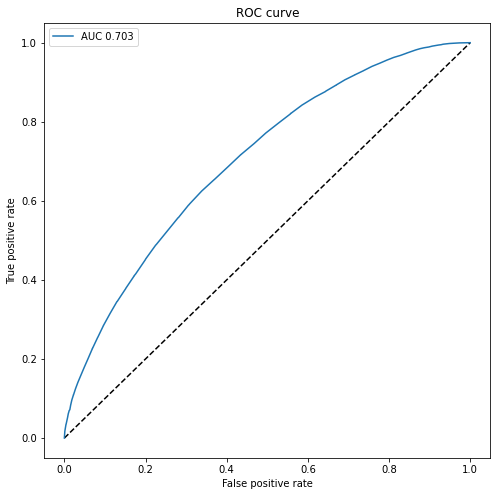

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(rf, X_test_vect, y_test_vect)
plot_ROC(auc,fpr,tpr)

With no common words

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_vect, y_train_vect)
y_pred = rf.predict(X_test_vect)
print(pd.crosstab(y_test_vect,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test_vect, y_pred))

Predicted      0      1
Actual                 
0          13938   8603
1           8827  13602
              precision    recall  f1-score   support

           0       0.61      0.62      0.62     22541
           1       0.61      0.61      0.61     22429

    accuracy                           0.61     44970
   macro avg       0.61      0.61      0.61     44970
weighted avg       0.61      0.61      0.61     44970



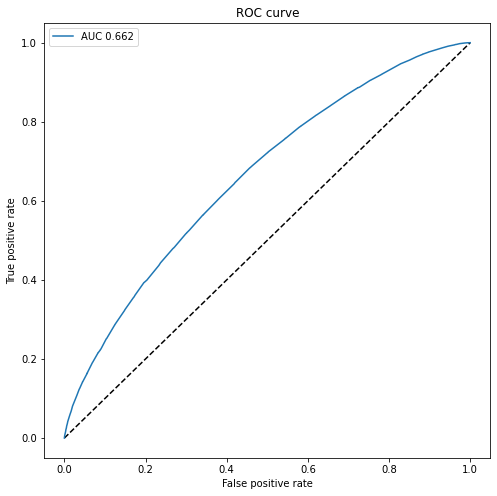

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(rf, X_test_vect, y_test_vect)
plot_ROC(auc,fpr,tpr)

##### Logistic Regression

In [ ]:
lr = LogisticRegression(solver='saga',C=10,max_iter=10000)
lr.fit(X_train_vect, y_train_vect)
y_pred = lr.predict(X_test_vect)
print(pd.crosstab(y_test_vect,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test_vect, y_pred))

Predicted      0      1
Actual                 
0          14051   8503
1           8143  14294
              precision    recall  f1-score   support

           0       0.63      0.62      0.63     22554
           1       0.63      0.64      0.63     22437

    accuracy                           0.63     44991
   macro avg       0.63      0.63      0.63     44991
weighted avg       0.63      0.63      0.63     44991



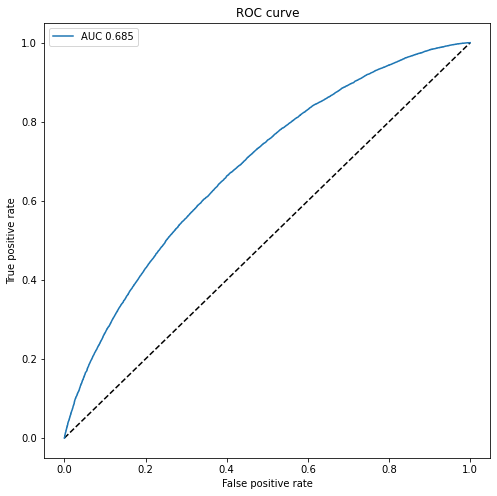

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(lr, X_test_vect, y_test_vect)
plot_ROC(auc,fpr,tpr)

With no common words

In [ ]:
lr = LogisticRegression(solver='saga',C=10,max_iter=10000)
lr.fit(X_train_vect, y_train_vect)
y_pred = lr.predict(X_test_vect)
print(pd.crosstab(y_test_vect,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test_vect, y_pred))

Predicted      0      1
Actual                 
0          13567   8974
1           8900  13529
              precision    recall  f1-score   support

           0       0.60      0.60      0.60     22541
           1       0.60      0.60      0.60     22429

    accuracy                           0.60     44970
   macro avg       0.60      0.60      0.60     44970
weighted avg       0.60      0.60      0.60     44970



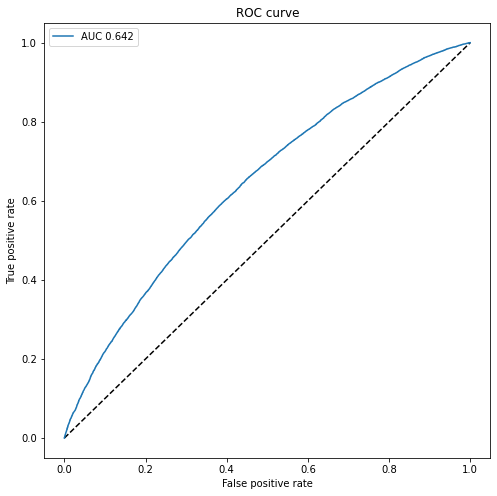

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(lr, X_test_vect, y_test_vect)
plot_ROC(auc,fpr,tpr)

##### Gradient Boosting

In [ ]:
grad_clf = GradientBoostingClassifier()
grad_clf.fit(X_train_vect, y_train_vect)
y_pred = grad_clf.predict(X_test_vect)
print(pd.crosstab(y_test_vect,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test_vect, y_pred))

Predicted      0      1
Actual                 
0          13425   9129
1           7655  14782
              precision    recall  f1-score   support

           0       0.64      0.60      0.62     22554
           1       0.62      0.66      0.64     22437

    accuracy                           0.63     44991
   macro avg       0.63      0.63      0.63     44991
weighted avg       0.63      0.63      0.63     44991



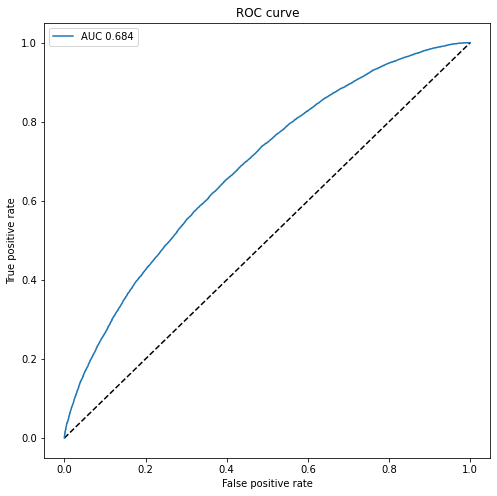

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(grad_clf, X_test_vect, y_test_vect)
plot_ROC(auc,fpr,tpr)

With no common words

In [ ]:
grad_clf = GradientBoostingClassifier()
grad_clf.fit(X_train_vect, y_train_vect)
y_pred = grad_clf.predict(X_test_vect)
print(pd.crosstab(y_test_vect,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test_vect, y_pred))

Predicted      0      1
Actual                 
0          13448   9093
1           9013  13416
              precision    recall  f1-score   support

           0       0.60      0.60      0.60     22541
           1       0.60      0.60      0.60     22429

    accuracy                           0.60     44970
   macro avg       0.60      0.60      0.60     44970
weighted avg       0.60      0.60      0.60     44970



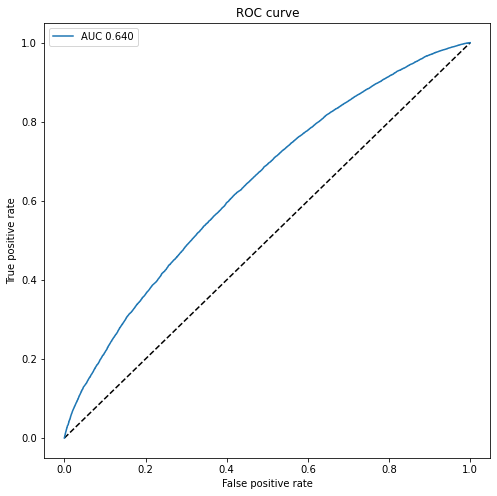

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(grad_clf, X_test_vect, y_test_vect)
plot_ROC(auc,fpr,tpr)

##### Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(X_train_vect, y_train_vect)
y_pred = nb.predict(X_test_vect)
print(pd.crosstab(y_test_vect,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test_vect, y_pred))

Predicted      0      1
Actual                 
0          13599   8955
1           9494  12943
              precision    recall  f1-score   support

           0       0.59      0.60      0.60     22554
           1       0.59      0.58      0.58     22437

    accuracy                           0.59     44991
   macro avg       0.59      0.59      0.59     44991
weighted avg       0.59      0.59      0.59     44991



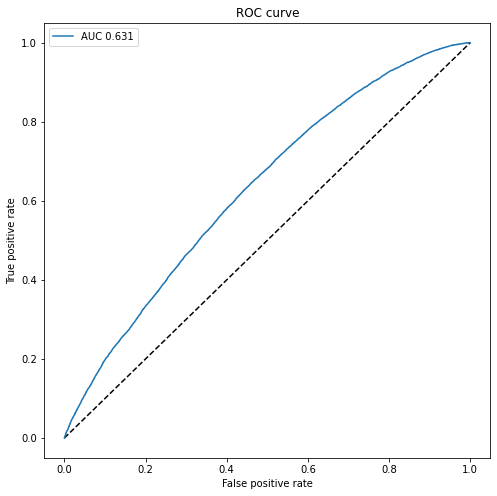

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(nb, X_test_vect, y_test_vect)
plot_ROC(auc,fpr,tpr)

With no common words

In [ ]:
nb = GaussianNB()
nb.fit(X_train_vect, y_train_vect)
y_pred = nb.predict(X_test_vect)
print(pd.crosstab(y_test_vect,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test_vect, y_pred))

Predicted      0      1
Actual                 
0          13674   8867
1          10334  12095
              precision    recall  f1-score   support

           0       0.57      0.61      0.59     22541
           1       0.58      0.54      0.56     22429

    accuracy                           0.57     44970
   macro avg       0.57      0.57      0.57     44970
weighted avg       0.57      0.57      0.57     44970



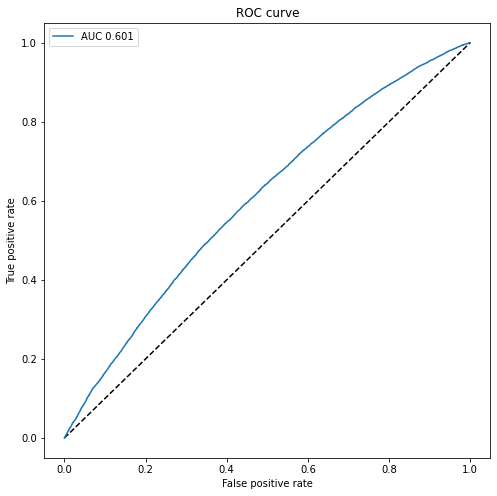

In [ ]:
# Obtain AUC, false positive rate, and true positive rate and plot
auc, fpr, tpr = get_auc_fpr_tpr(nb, X_test_vect, y_test_vect)
plot_ROC(auc,fpr,tpr)

# Baseline Deep Learning Models

In [32]:
#@title Helper Functions: Baseline DL
# Training loop
def train(model, device, train_iter, valid_iter, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    for epoch in range(epochs):
      #train
      model.train()
      running_loss = 0.
      correct, total = 0, 0 

      for idx, batch in enumerate(train_iter):
        text = batch[0]
        target = batch[1]
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        # add micro for coding training loop
        optimizer.zero_grad()
        output = model(text)
 
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # get accuracy 
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
      train_loss.append(running_loss/len(train_iter))
      train_acc.append(correct/total)

      print(f'Epoch: {epoch + 1},  Training Loss: {running_loss/len(train_iter):.4f}, Training Accuracy: {100*correct/total: .2f}%')

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0 

      with torch.no_grad():
        for idx, batch in enumerate(valid_iter):
            text = batch[0]
            target = batch[1]
            target = torch.autograd.Variable(target).long()
            text, target = text.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(text)
    
            loss = criterion(output, target)
            running_loss += loss.item()

            # get accuracy 
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(valid_iter))
      validation_acc.append(correct/total)

      print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, Validation Accuracy: {100*correct/total: .2f}%')
  
    return train_loss, train_acc, validation_loss, validation_acc

# Test loop
def test(model,  device, test_iter):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(test_iter):
        text = batch[0]
        target = batch[1]
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        outputs = model(text)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc

# Define a DataSet Class which simply return (x, y) pair
class SimpleDataset(Dataset):
  def __init__(self, x, y):
    self.datalist=[(x[i], y[i]) for i in range(len(y))]
  def __len__(self):
    return len(self.datalist)
  def __getitem__(self,idx):
    return self.datalist[idx]
      
# Data Loader
def create_data_loader(X, y, batch_size, shuffle):
  X_sampled = np.array(X)
  y_sampled = np.array(y).astype(int)
  dataset = SimpleDataset(X_sampled, y_sampled)
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
  return loader

# Change words to numeric based on mapping
def map_word_vocab(sentence):
  idxs = [vocab[w] for w in sentence.split()]
  return idxs

# Pad tweets so we can get tensors from them
def pad_tweets(tweet,max_len):
  while len(tweet) < max_len:
    tweet.append(0)

  if len(tweet) > max_len:
    tweet = tweet[:max_len]
  return torch.tensor(tweet, dtype=torch.long)

# Load weights from word2vec
def load_pretrained_embedding(weights_matrix):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.weight.data.copy_(torch.from_numpy(weights_matrix))
    emb_layer.weight.requires_grad = False

    return emb_layer

## Obtain Samples

In [41]:
df['party'].value_counts()

1    656287
0    562341
Name: party, dtype: int64

In [66]:
# Just randomly pick 300k from each party
df_dem = df[df['party'] == 0].sample(n=300000, random_state=47)
df_rep = df[df['party'] == 1].sample(n=300000, random_state=47)

# Stack them
df_sample = pd.concat([df_dem,df_rep],ignore_index=True)

In [67]:
# Get training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_sample['clean_tweet'], df_sample['party'], test_size = 0.3, random_state=47, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=47)

## With TF-IDF

In [68]:
# Needs a dense representation -- different from those above
max_features=500
vectorizer = TfidfVectorizer(max_features=max_features)
tfidf_fit = vectorizer.fit(X_train)
X_train_vect = tfidf_preprocess(X_train, tfidf_fit)
X_val_vect = tfidf_preprocess(X_val, tfidf_fit)
X_test_vect = tfidf_preprocess(X_test, tfidf_fit)

In [45]:
# Obtain data loaders
batch_size=32
train_loader = create_data_loader(X_train_vect, y_train, batch_size, True)
valid_loader = create_data_loader(X_val_vect, y_val, batch_size, False)
test_loader = create_data_loader(X_test_vect, y_test, batch_size, False)

In [46]:
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.hidden = nn.Linear(hidden_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = x.float()
    x = F.relu(self.fc1(x))
    x = F.relu(self.hidden(x))
    x = self.fc2(x)
    
    return x

In [47]:
# Hyperparameters
learning_rate = 0.001
output_size = 2
hidden_size = 16
epochs = 10

net = Net(max_features, hidden_size, output_size)
net.to(device)
net_train_loss, net_train_acc, net_validation_loss, net_validation_acc = train(net, device, train_loader, valid_loader, epochs, learning_rate)
test_accuracy = test(net, device, test_loader)
print('Test Accuracy: ',  test_accuracy, '%\n')

KeyboardInterrupt: ignored

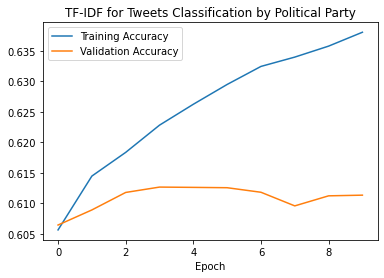

In [ ]:
# Plot accuracy curve
plot_train_val(np.arange(0,epochs), net_train_acc, net_validation_acc, 'Training Accuracy', 'Validation Accuracy', 'TF-IDF for Tweets Classification by Political Party')

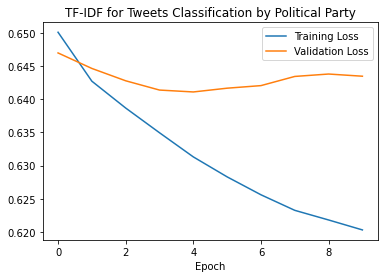

In [ ]:
# Plot loss curve
plot_train_val(np.arange(0,epochs), net_train_loss, net_validation_loss, 'Training Loss', 'Validation Loss', 'TF-IDF for Tweets Classification by Political Party')

## With just text

In [69]:
# Get vocab
tweets = list(df_sample['clean_tweet'])

vocab = {}
vocab_index = 0
for i in range(len(tweets)):
  for token in tweets[i].split():
    if token not in vocab:
      vocab[token] = vocab_index
      vocab_index += 1
# for i in range(len(X_test_fun)):
#   for token in X_test_fun[i].split():
#     if token not in vocab:
#       vocab[token] = vocab_index
#       vocab_index += 1

In [70]:
len(vocab)

87156

In [ ]:
## This data used to discriminate on generative tweets
X_test_fun = X_test[:0]
X_test_fun[0] = "the united states of america is attempting to build a wall along the mexican border, despite a petition from some supporters claiming the wall is necessary to keep the country secure"
X_test_fun[1] = "president barrack obama was a brave man and dedicated patriot of the republic he did what he was willing to do to preserve his national security he was prepared to do just that"
X_test_fun[2] = "president donald trump was a leader of the republican party the presidents views about womens rights and reproductive rights are varied and have changed with the presidential election most commentators including senator bob dole agree with many aspects of trumps view"
y_test_fun = y_test[:0]
y_test_fun[0] = 1
y_test_fun[1] = 1
y_test_fun[2] = 1

In [71]:
# Change words to numeric based on mapping
X_train = X_train.apply(map_word_vocab)
X_val = X_val.apply(map_word_vocab)
X_test = X_test.apply(map_word_vocab)
#X_test_fun = X_test_fun.apply(map_word_vocab)

In [72]:
# Pad tweets so we can get tensors from them
X_train = X_train.apply(lambda x: pad_tweets(x,20))
X_val = X_val.apply(lambda x: pad_tweets(x,20))
X_test = X_test.apply(lambda x: pad_tweets(x,20))
#X_test_fun = X_test_fun.apply(lambda x: pad_tweets(x, 20))

In [73]:
# Obtain data loaders
batch_size=32
train_loader = create_data_loader(X_train, y_train, batch_size, True)
valid_loader = create_data_loader(X_val, y_val, batch_size, False)
test_loader = create_data_loader(X_test, y_test, batch_size, False)
#test_fun_loader = create_data_loader(X_test_fun, y_test_fun, batch_size, False)

#### LSTM

In [ ]:
class LSTM(nn.Module):
  def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size):
    super(LSTM, self).__init__()

    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.n_layers = layers

    self.word_embeddings = nn.Embedding(vocab_size,embed_size)
    self.dropout = nn.Dropout(0.5)
    self.lstm = nn.LSTM(embed_size, hidden_size, self.n_layers)
    self.fc = nn.Linear(hidden_size*self.n_layers, output_size)

  def forward(self, input_sentences):
    input = self.word_embeddings(input_sentences).permute(1,0,2)
    
    hidden = (torch.randn(self.n_layers, input.shape[1], self.hidden_size).to(device),
            torch.randn(self.n_layers, input.shape[1], self.hidden_size).to(device))

    input = self.dropout(input)

    output, hidden = self.lstm(input, hidden)

    h_n = hidden[0].permute(1,0,2)
    h_n = h_n.contiguous().view(h_n.shape[0], -1)

    logits = self.fc(h_n)
    return logits

In [ ]:
# Hyperparameters
learning_rate = 0.0003
output_size = 2
hidden_size = 16
embedding_length = 300
epochs = 5
layers = 2

lstm_model = LSTM(layers, output_size, hidden_size, len(vocab), embedding_length)
lstm_model.to(device)
lstm_train_loss, lstm_train_acc, lstm_validation_loss, lstm_validation_acc = train(lstm_model, device, train_loader, valid_loader, epochs, learning_rate)
test_accuracy = test(lstm_model, device, test_loader)
#test_fun_accuracy = test(lstm_model, device, test_fun_loader)
print('Test Accuracy: ',  test_accuracy, '%\n')
#print('Geneartive Guess Republican: ',  test_fun_accuracy, '%\n')

Epoch: 1,  Training Loss: 0.6813, Training Accuracy:  55.62%
Validation Loss: 0.6447, Validation Accuracy:  62.92%
Epoch: 2,  Training Loss: 0.6418, Training Accuracy:  62.63%
Validation Loss: 0.6071, Validation Accuracy:  66.26%
Epoch: 3,  Training Loss: 0.6137, Training Accuracy:  65.65%
Validation Loss: 0.5839, Validation Accuracy:  68.33%
Epoch: 4,  Training Loss: 0.5926, Training Accuracy:  67.49%
Validation Loss: 0.5697, Validation Accuracy:  69.58%
Epoch: 5,  Training Loss: 0.5757, Training Accuracy:  68.88%
Validation Loss: 0.5585, Validation Accuracy:  70.37%


AttributeError: ignored

In [ ]:
X_test_fun.type

AttributeError: ignored

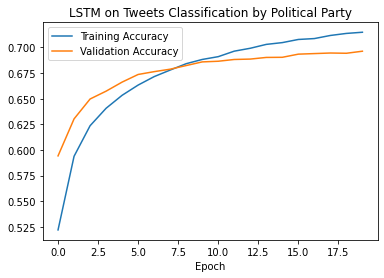

In [ ]:
# Plot accuracy curve
plot_train_val(np.arange(0,epochs), lstm_train_acc, lstm_validation_acc, 'Training Accuracy', 'Validation Accuracy', 'LSTM on Tweets Classification by Political Party')

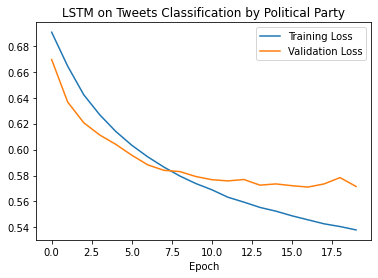

In [ ]:
# Plot loss curve
plot_train_val(np.arange(0,epochs), lstm_train_loss, lstm_validation_loss, 'Training Loss', 'Validation Loss', 'LSTM on Tweets Classification by Political Party')

### Bidirectional LSTM

In [ ]:
class biLSTM(nn.Module):
  def __init__(self, output_size, hidden_size, vocab_size, embed_size):
    super(biLSTM, self).__init__()

    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embed_size = embed_size

    self.word_embeddings = nn.Embedding(vocab_size,embed_size)
    self.dropout = nn.Dropout(0.5)
    self.bilstm = nn.LSTM(embed_size, hidden_size, num_layers=2, bidirectional=True)
    self.fc = nn.Linear(hidden_size*4,output_size)

  def forward(self, input_sentences):
    
    input = self.word_embeddings(input_sentences).permute(1, 0, 2)
    hidden = (torch.randn(4, input.shape[1], self.hidden_size).to(device),
            torch.randn(4, input.shape[1], self.hidden_size).to(device))
    input = self.dropout(input)
    
    output, hidden = self.bilstm(input, hidden)

    h_n = hidden[0].permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.shape[0], -1)
    logits = self.fc(h_n)
    return logits

In [ ]:
# Hyperparameters
learning_rate = 0.0003
batch_size = 32
output_size = 2
hidden_size = 16
embedding_length = 300
epochs = 20

# Model, training and testing 
biLSTM_model = biLSTM(output_size, hidden_size, len(vocab), embedding_length)
biLSTM_model.to(device)
biLSTM_train_loss, biLSTM_train_acc, biLSTM_validation_loss, biLSTM_validation_acc = train(biLSTM_model, device, train_loader, valid_loader, epochs, learning_rate)
test_accuracy = test(biLSTM_model, device, test_loader)
print('Test Accuracy: ',  test_accuracy, '%\n')

Epoch: 1,  Training Loss: 0.6764, Training Accuracy:  56.40%
Validation Loss: 0.6394, Validation Accuracy:  62.47%
Epoch: 2,  Training Loss: 0.6441, Training Accuracy:  62.00%
Validation Loss: 0.6160, Validation Accuracy:  65.26%
Epoch: 3,  Training Loss: 0.6233, Training Accuracy:  64.24%
Validation Loss: 0.6029, Validation Accuracy:  66.43%
Epoch: 4,  Training Loss: 0.6089, Training Accuracy:  65.64%
Validation Loss: 0.5919, Validation Accuracy:  67.28%
Epoch: 5,  Training Loss: 0.5971, Training Accuracy:  66.74%
Validation Loss: 0.5876, Validation Accuracy:  67.80%
Epoch: 6,  Training Loss: 0.5877, Training Accuracy:  67.53%
Validation Loss: 0.5808, Validation Accuracy:  68.21%
Epoch: 7,  Training Loss: 0.5793, Training Accuracy:  68.17%
Validation Loss: 0.5769, Validation Accuracy:  68.55%
Epoch: 8,  Training Loss: 0.5719, Training Accuracy:  68.79%
Validation Loss: 0.5746, Validation Accuracy:  68.92%
Epoch: 9,  Training Loss: 0.5659, Training Accuracy:  69.22%
Validation Loss: 0.

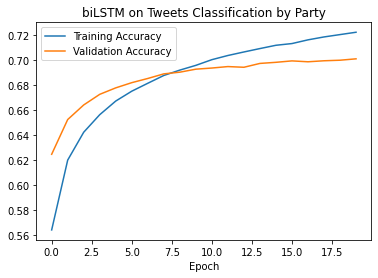

In [ ]:
# Plot accuracy curve
plot_train_val(np.arange(0,epochs), biLSTM_train_acc, biLSTM_validation_acc,'Training Accuracy', 'Validation Accuracy', 'biLSTM on Tweets Classification by Party')

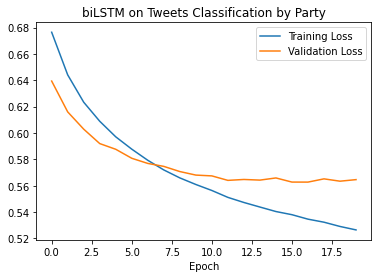

In [ ]:
# Plot loss curve
plot_train_val(np.arange(0,epochs), biLSTM_train_loss, biLSTM_validation_loss,'Training Loss', 'Validation Loss', 'biLSTM on Tweets Classification by Party')

## With word embeddings

In [54]:
# Get vocab
tweets = list(df_sample['clean_tweet'])

vocab = {}
vocab_index = 0
for i in range(len(tweets)):
  for token in tweets[i].split():
    if token not in vocab:
      vocab[token] = vocab_index
      vocab_index += 1

In [55]:
len(vocab)

87548

In [56]:
# Obtain weights matrix
matrix_len = len(vocab)
weights_matrix = np.zeros((matrix_len, 100))
words_found = 0
words_missing = []

for i, word in enumerate(vocab):
    try: 
        weights_matrix[i] = model[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(100, ))
        words_missing.append(word)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [57]:
words_found

58641

In [58]:
# Change words to numeric based on mapping
X_train = X_train.apply(map_word_vocab)
X_val = X_val.apply(map_word_vocab)
X_test = X_test.apply(map_word_vocab)

TypeError: ignored

In [ ]:
# Pad tweets so we can get tensors from them
X_train = X_train.apply(lambda x: pad_tweets(x,20))
X_val = X_val.apply(lambda x: pad_tweets(x,20))
X_test = X_test.apply(lambda x: pad_tweets(x,20))

In [ ]:
# Obtain data loaders
batch_size=32
train_loader = create_data_loader(X_train, y_train, batch_size, True)
valid_loader = create_data_loader(X_val, y_val, batch_size, False)
test_loader = create_data_loader(X_test, y_test, batch_size, False)

### LSTM

In [ ]:
class LSTM(nn.Module):
  def __init__(self, weights_matrix, layers, output_size, hidden_size, vocab_size, embed_size):
    super(LSTM, self).__init__()

    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.n_layers = layers

    self.word_embeddings = load_pretrained_embedding(weights_matrix)
    self.dropout = nn.Dropout(0.5)
    self.lstm = nn.LSTM(embed_size, hidden_size, self.n_layers)
    self.fc = nn.Linear(hidden_size*self.n_layers, output_size)

  def forward(self, input_sentences):
    input = self.word_embeddings(input_sentences).permute(1,0,2)
    
    hidden = (torch.randn(self.n_layers, input.shape[1], self.hidden_size).to(device),
            torch.randn(self.n_layers, input.shape[1], self.hidden_size).to(device))

    input = self.dropout(input)

    output, hidden = self.lstm(input, hidden)

    h_n = hidden[0].permute(1,0,2)
    h_n = h_n.contiguous().view(h_n.shape[0], -1)

    logits = self.fc(h_n)
    return logits

In [ ]:
# Hyperparameters
learning_rate = 0.0003
batch_size = 32
output_size = 2
hidden_size = 16
vocab_size = weights_matrix.shape[0]
embedding_length = weights_matrix.shape[1]
epochs = 20
num_layers = 2

LSTM_model = LSTM(weights_matrix, num_layers, output_size, hidden_size, vocab_size, embedding_length)
LSTM_model.to(device)
lstm_train_loss, lstm_train_acc, lstm_validation_loss, lstm_validation_acc = train(LSTM_model, device, train_loader, valid_loader, epochs, learning_rate)

Epoch: 1,  Training Loss: 0.6708, Training Accuracy:  57.78%
Validation Loss: 0.6386, Validation Accuracy:  63.22%
Epoch: 2,  Training Loss: 0.6481, Training Accuracy:  61.68%
Validation Loss: 0.6209, Validation Accuracy:  64.85%
Epoch: 3,  Training Loss: 0.6389, Training Accuracy:  62.69%
Validation Loss: 0.6134, Validation Accuracy:  65.40%
Epoch: 4,  Training Loss: 0.6334, Training Accuracy:  63.26%
Validation Loss: 0.6076, Validation Accuracy:  65.93%
Epoch: 5,  Training Loss: 0.6304, Training Accuracy:  63.54%
Validation Loss: 0.6067, Validation Accuracy:  65.53%
Epoch: 6,  Training Loss: 0.6272, Training Accuracy:  63.80%
Validation Loss: 0.6027, Validation Accuracy:  66.38%
Epoch: 7,  Training Loss: 0.6247, Training Accuracy:  63.89%
Validation Loss: 0.6003, Validation Accuracy:  66.38%
Epoch: 8,  Training Loss: 0.6232, Training Accuracy:  64.11%
Validation Loss: 0.5964, Validation Accuracy:  66.70%
Epoch: 9,  Training Loss: 0.6219, Training Accuracy:  64.27%
Validation Loss: 0.

In [ ]:
test_accuracy = test(LSTM_model, device, test_loader)
print('Test Accuracy: ',  test_accuracy, '%\n')

Test Accuracy:  67.40388888888889 %



In [ ]:
torch.save(LSTM_model.state_dict(), "/content/drive/Shareddrives/CIS522: US Political Tweets/pretrained/lstm_word_embed")

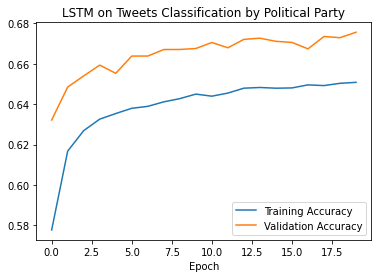

In [ ]:
# Plot accuracy curve
plot_train_val(np.arange(0,epochs), lstm_train_acc, lstm_validation_acc, 'Training Accuracy', 'Validation Accuracy', 'LSTM on Tweets Classification by Political Party')

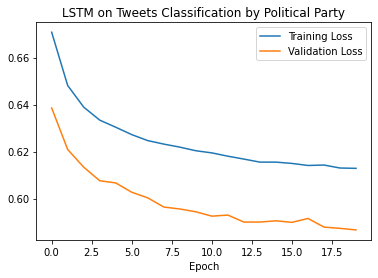

In [ ]:
# Plot loss curve
plot_train_val(np.arange(0,epochs), lstm_train_loss, lstm_validation_loss, 'Training Loss', 'Validation Loss', 'LSTM on Tweets Classification by Political Party')

### Bidirectional LSTM

In [ ]:
class biLSTM(nn.Module):
  def __init__(self, weights_matrix, output_size, hidden_size, vocab_size, embed_size):
    super(biLSTM, self).__init__()

    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embed_size = embed_size

    self.word_embeddings = load_pretrained_embedding(weights_matrix)
    self.dropout = nn.Dropout(0.5)
    self.bilstm = nn.LSTM(embed_size, hidden_size, num_layers=2, bidirectional=True)
    self.fc = nn.Linear(hidden_size*4,output_size)

  def forward(self, input_sentences):
    input = self.word_embeddings(input_sentences).permute(1, 0, 2)
    hidden = (torch.randn(4, input.shape[1], self.hidden_size).to(device),
            torch.randn(4, input.shape[1], self.hidden_size).to(device))
    input = self.dropout(input)
    
    output, hidden = self.bilstm(input, hidden)

    h_n = hidden[0].permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.shape[0], -1)
    logits = self.fc(h_n)
    return logits

In [ ]:
# Hyperparameters
learning_rate = 0.0001
batch_size = 32
output_size = 2
hidden_size = 16
vocab_size = weights_matrix.shape[0]
embedding_length = weights_matrix.shape[1]
epochs = 20
num_layers = 2

# Model, training and testing 
biLSTM_model = biLSTM(weights_matrix, output_size, hidden_size, len(vocab), embedding_length)
biLSTM_model.to(device)
biLSTM_train_loss, biLSTM_train_acc, biLSTM_validation_loss, biLSTM_validation_acc = train(biLSTM_model, device, train_loader, valid_loader, epochs, learning_rate)
test_accuracy = test(biLSTM_model, device, test_loader)
print('Test Accuracy: ',  test_accuracy, '%\n')

Epoch: 1,  Training Loss: 0.6867, Training Accuracy:  54.09%
Validation Loss: 0.6719, Validation Accuracy:  58.07%
Epoch: 2,  Training Loss: 0.6735, Training Accuracy:  57.71%
Validation Loss: 0.6626, Validation Accuracy:  59.44%
Epoch: 3,  Training Loss: 0.6673, Training Accuracy:  58.77%
Validation Loss: 0.6544, Validation Accuracy:  60.85%
Epoch: 4,  Training Loss: 0.6631, Training Accuracy:  59.33%
Validation Loss: 0.6498, Validation Accuracy:  61.27%
Epoch: 5,  Training Loss: 0.6587, Training Accuracy:  60.04%
Validation Loss: 0.6446, Validation Accuracy:  61.92%
Epoch: 6,  Training Loss: 0.6562, Training Accuracy:  60.41%
Validation Loss: 0.6414, Validation Accuracy:  62.36%
Epoch: 7,  Training Loss: 0.6536, Training Accuracy:  60.63%
Validation Loss: 0.6379, Validation Accuracy:  62.70%
Epoch: 8,  Training Loss: 0.6503, Training Accuracy:  61.13%
Validation Loss: 0.6353, Validation Accuracy:  62.95%
Epoch: 9,  Training Loss: 0.6479, Training Accuracy:  61.24%
Validation Loss: 0.

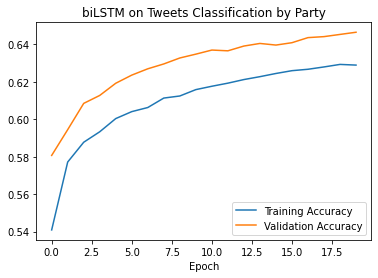

In [ ]:
# Plot accuracy curve
plot_train_val(np.arange(0,epochs), biLSTM_train_acc, biLSTM_validation_acc,'Training Accuracy', 'Validation Accuracy', 'biLSTM on Tweets Classification by Party')

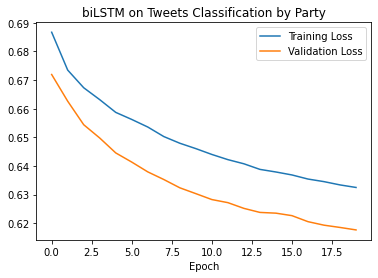

In [ ]:
# Plot loss curve
plot_train_val(np.arange(0,epochs), biLSTM_train_loss, biLSTM_validation_loss,'Training Loss', 'Validation Loss', 'biLSTM on Tweets Classification by Party')

# BERT

In [33]:
#@title Helper Functions: BERT
party_label_mapping = {
    "Democrat": 0,
    "Republican": 1
}

# Get sets in basic format for BERT
def transform_set(X,y):
  sentence_pairs = []
  for tweet,label in zip(X,y):
    sentence_pairs.append({
      "tweet": tweet,
      "label": label
    })
  return sentence_pairs

# Change sets to tensor format
def convert_sentence_pair_to_tensor_input(sentence_pairs, label_mapping):
    input_examples = []
    for pair in sentence_pairs:
        input_examples.append(
            InputExample(guid="", # We don't really need this
                         text_a=pair["tweet"], 
                         label=pair['label'])
        )

    label_list = [val for _, val in label_mapping.items()]

    features = convert_examples_to_features(input_examples,
                                                   tokenizer,
                                                   label_list=label_list,
                                                   max_length=128,  
                                                   output_mode="classification")
    
    input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    labels = torch.tensor([f.label for f in features], dtype=torch.long)

    dataset = TensorDataset(input_ids, attention_mask, token_type_ids, labels)

    return dataset

# Get accuracy
def accuracy(preds, labels):
    return (preds == labels).mean()

# Train
def train_BERT(bert_model, train_dataset, hyperparams):
  bert_model.to('cuda')
  train_sampler = RandomSampler(train_dataset)
  train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=hyperparams["training_batch_size"])
  optimizer = AdamW(bert_model.parameters(), lr=hyperparams['learning_rate'], correct_bias=False)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=hyperparams['num_warmup_steps'], num_training_steps=len(train_dataloader))

  global_step = 0
  tr_loss = 0.0
  bert_model.zero_grad()
  bert_model.train()

  for epc in range(hyperparams["num_training_epoch"]):
      print("Epoch #{}: \n".format(epc))
      epoch_iterator = tqdm.notebook.tqdm(train_dataloader, desc="Training Steps")
      avg_loss_over_epoch = []
      for step, batch in enumerate(epoch_iterator):
          batch = tuple(t.to("cuda") for t in batch)
          inputs = {'input_ids': batch[0],
                    'attention_mask': batch[1],
                    'token_type_ids': batch[2],
                    'labels': batch[3]}

          outputs = bert_model(**inputs)
          loss = outputs[0]

          loss.backward()
          torch.nn.utils.clip_grad_norm_(bert_model.parameters(), hyperparams["max_grad_norm"])
          tr_loss += loss.item()

          optimizer.step()
          scheduler.step()
          bert_model.zero_grad()

# Evaluate
def eval_BERT(bert_model, eval_dataset, hyperparams):
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=hyperparams["eval_batch_size"])

  predictions = None
  out_label_ids = None

  for batch in tqdm.notebook.tqdm(eval_dataloader, desc="Evaluating..."):
      bert_model.eval()
      batch = tuple(t.to("cuda") for t in batch)
      inputs = {'input_ids': batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2],
                'labels': batch[3]}

      with torch.no_grad():
          outputs = bert_model(**inputs)
          logits = outputs[1]

      if predictions is None:
          predictions = logits.detach().cpu().numpy()
          out_label_ids = inputs['labels'].detach().cpu().numpy()
      else:
          predictions = np.append(predictions, logits.detach().cpu().numpy(), axis=0)
          out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

  predictions = np.argmax(predictions, axis=1)
  acc = accuracy(predictions, out_label_ids)
  
  return acc, predictions

## Obtain Samples

In [74]:
# Just randomly pick 300k from each party
df_dem = df[df['party'] == 0].sample(n=300000, random_state=47)
df_rep = df[df['party'] == 1].sample(n=300000, random_state=47)

# Stack them
df_sample = pd.concat([df_dem,df_rep],ignore_index=True)

In [75]:
# Get training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_sample['no_common'], df_sample['party'], test_size = 0.3, random_state=47, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=47)

In [76]:
# Get sets in format for BERT
training_sentence_pairs = transform_set(X_train,y_train)
dev_sentence_pairs = transform_set(X_val,y_val)
test_sentence_pairs = transform_set(X_test,y_test)

In [77]:
# Change to tensor format (note: need to get tokenizer before running (run cell below))
train_dataset = convert_sentence_pair_to_tensor_input(training_sentence_pairs, party_label_mapping)
dev_dataset = convert_sentence_pair_to_tensor_input(dev_sentence_pairs, party_label_mapping)
test_dataset = convert_sentence_pair_to_tensor_input(test_sentence_pairs, party_label_mapping)

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


## BERT Experimentation

### BERT-Mini

In [78]:
bert_model_type = 'google/bert_uncased_L-4_H-256_A-4'

bert_model = BertForSequenceClassification.from_pretrained(bert_model_type)
config = BertConfig.from_pretrained(bert_model_type)
tokenizer = BertTokenizer.from_pretrained(bert_model_type)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

In [84]:
# Set hyperparameters
hyperparams = {
    "num_training_epoch": 3,
    "learning_rate": 1e-3,
    "training_batch_size": 16,
    "eval_batch_size": 8,
    "max_grad_norm": 5.0,
    "num_warmup_steps": 10
}

In [85]:
# Train
train_BERT(bert_model, train_dataset, hyperparams)

Epoch #0: 




Epoch #1: 




Epoch #2: 



In [ ]:
# Evaluate on dev set (BERT-mini)
acc, predictions = eval_BERT(bert_model, dev_dataset, hyperparams)
print("The accuracy on dev set = {}".format(acc))


The accuracy on dev set = 0.7639285714285714


In [ ]:
# Test set (BERT-mini)
acc, predictions = eval_BERT(bert_model, test_dataset, hyperparams)
print("The accuracy on test set = {}".format(acc))


The accuracy on dev set = 0.7612333333333333


### BERT-Small

In [79]:
bert_model_type = 'google/bert_uncased_L-4_H-512_A-8'
# bert_model_type = 'google/bert_uncased_L-12_H-768_A-12'

bert_model = BertForSequenceClassification.from_pretrained(bert_model_type)
config = BertConfig.from_pretrained(bert_model_type)
tokenizer = BertTokenizer.from_pretrained(bert_model_type)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

In [80]:
# Set hyperparameters
hyperparams = {
    "num_training_epoch": 3,
    "learning_rate": 1e-5,
    "training_batch_size": 16,
    "eval_batch_size": 8,
    "max_grad_norm": 5.0,
    "num_warmup_steps": 10
}

In [81]:
# Train
train_BERT(bert_model, train_dataset, hyperparams)

Epoch #0: 



KeyboardInterrupt: ignored

In [ ]:
# Evaluate on dev set
acc, predictions = eval_BERT(bert_model, dev_dataset, hyperparams)
print("The accuracy on dev set = {}".format(acc))


The accuracy on dev set = 0.794515873015873


In [ ]:
# Test set
acc, predictions = eval_BERT(bert_model, test_dataset, hyperparams)
print("The accuracy on train set = {}".format(acc))


The accuracy on train set = 0.7927833333333333


## Save model to reload back if necessary

In [ ]:
# Save model
output_dir = '/content/drive/Shareddrives/CIS522: US Political Tweets/BERT_model/' + bert_model_type + '/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

bert_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
config.save_pretrained(output_dir)

In [ ]:
# Use this to load it back
bert_model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

bert_model = bert_model.to("cuda")

# GPT Generator & Discriminator


In [9]:
#@title Installations
# Large amounts of code copied from CIS522 W10_Homework
!pip install transformers
!pip install datasets

In [10]:
#@title Imports
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import Trainer, TrainingArguments

In [11]:
#@title Load Datset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

Reusing dataset wikitext (/root/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/aa5e094000ec7afeb74c3be92c88313cd6f132d564c7effd961c10fd47c76f20)


In [12]:
#@title Tokenize
#Define the model Checkpoint
model_checkpoint = "distilgpt2"

#Tokenizer  
#To tokenize all our texts with the same vocabulary that was used when training the model, we have to download a pretrained tokenizer. 
#This is all done by the AutoTokenizer class:  
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

#We define a function to call the tokenizer on our texts:
def tokenize_function(examples):
    return tokenizer(examples["text"])

#Apply tokenizer to all the splits in our datasets object and drop the text coolumn
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

In [13]:
#@title Fine Tuning
training_args = TrainingArguments(
    "test-clm",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=2,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
)
trainer.train()

NameError: ignored

In [7]:
ZPROMPT_TEXT = "Congress has once again"
run_generations(PROMPT_TEXT)


NameError: ignored

In [14]:
"The United States of America is attempting to build a wall along the Mexican border, despite a petition from some supporters claiming the wall is necessary to keep the country secure"
"President Barrack Obama was a brave man and dedicated patriot of the Republic. He did what he was willing to do to preserve his national security. He was prepared to do just that."
"President Donald Trump was a leader of the Republican Party. The President's views about women's rights and reproductive rights are varied, and have changed with the presidential election."

"President Donald Trump was a leader of the Republican Party. The President's views about women's rights and reproductive rights are varied, and have changed with the presidential election."